In [27]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "mfcc_data_20s.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfccs"])
    y = np.array(data["labels"])
    genres = data["genres"]

    print("Data succesfully loaded!")

    return  X, y, genres

In [2]:
# load data
X, y, genres = load_data(DATA_PATH)

Data succesfully loaded!


In [3]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(len(genres), activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 17240)             0         
                                                                 
 dense (Dense)               (None, 512)               8827392   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 8,975,818
Trainable params: 8,975,818
Non-trainable params: 0
_________________________________________________________________


In [5]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
22/22 [==============================] - 7s 212ms/step - loss: 21.7832 - accuracy: 0.2833 - val_loss: 11.7346 - val_accuracy: 0.3167
Epoch 2/50
22/22 [==============================] - 3s 144ms/step - loss: 5.4938 - accuracy: 0.4278 - val_loss: 6.5355 - val_accuracy: 0.2533
Epoch 3/50
22/22 [==============================] - 3s 137ms/step - loss: 2.8735 - accuracy: 0.4649 - val_loss: 4.0877 - val_accuracy: 0.3000
Epoch 4/50
22/22 [==============================] - 3s 136ms/step - loss: 1.7247 - accuracy: 0.5193 - val_loss: 4.3623 - val_accuracy: 0.2800
Epoch 5/50
22/22 [==============================] - 3s 137ms/step - loss: 1.5050 - accuracy: 0.4964 - val_loss: 3.1050 - val_accuracy: 0.3067
Epoch 6/50
22/22 [==============================] - 3s 135ms/step - loss: 1.2266 - accuracy: 0.5694 - val_loss: 4.0448 - val_accuracy: 0.3467
Epoch 7/50
22/22 [==============================] - 3s 137ms/step - loss: 1.1680 - accuracy: 0.6466 - val_loss: 3.7151 - val_accuracy: 0.3367
Epoc

In [6]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 0s 22ms/step - loss: 5.7853 - accuracy: 0.4200
test loss, test acc: [5.785305976867676, 0.41999998688697815]


In [7]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for tests")
predictions = model.predict(X_test)

Generate predictions for tests
10/10 [==============================] - 1s 17ms/step


In [25]:
correct = [0 for genre in genres]
pred_data = [[0 for g in genres] for genre in genres]
genre_count = [0 for genre in genres]
for i in range(predictions.shape[0]):
    max_confidence = max(predictions[i])
    pred = np.argmax(predictions[i])
    actual = y_test[i]
    
    genre_count[actual] += 1
    pred_data[actual] += predictions[i]
    
    if pred == actual:
        correct[actual] += 1
#     print('Prediction:', genres[pred], '\tActual:', genres[actual], '\nConfidence:', max(predictions[i]),'\n')

pred_data = np.asarray(pred_data) / genre_count
print(pred_data)

[[3.87681334e-01 6.33009403e-02 1.26080885e-01 9.45188442e-03
  3.79700560e-02 2.82468380e-01 6.28164375e-02 3.16836582e-06
  8.73221704e-05 1.08724406e-01]
 [9.85251685e-05 8.54322916e-01 8.74908043e-03 2.07731715e-02
  7.91647433e-07 1.10657551e-02 3.44957211e-02 3.33651990e-04
  1.25693695e-09 4.68265093e-02]
 [1.67850116e-01 2.59191195e-02 3.13400569e-01 6.08377887e-02
  4.51870074e-02 3.30862728e-01 7.40258207e-05 2.92915462e-02
  2.64739436e-02 9.11566329e-02]
 [2.30723652e-01 2.93857775e-04 8.19154153e-02 1.24664994e-01
  1.50042971e-01 1.07161865e-01 8.84295981e-02 3.56415673e-02
  5.81267196e-02 2.91726777e-01]
 [6.99491440e-02 8.43090387e-02 1.60091034e-01 3.60009281e-03
  3.63819490e-01 6.95178511e-02 3.75116736e-02 7.42751231e-02
  6.27511715e-02 1.05799069e-04]
 [1.70730843e-01 1.75081322e-01 5.22420944e-02 2.69000448e-02
  4.17759420e-02 4.54835040e-01 7.22892287e-09 3.56769909e-04
  3.94311254e-02 1.67236346e-03]
 [5.95950317e-02 4.24214708e-04 1.24548094e-05 1.07842199e

In [26]:
curr_genre = 0
for c,g in zip(correct,genre_count):
    print(genres[curr_genre], ': ', c / g * 100,'% correct')
    print('Prediction distribution: ', pred_data[curr_genre],'\n')
    curr_genre += 1

print('\nTotal: ', sum(correct) / sum(genre_count) * 100, '% correct')

blues :  37.5 % correct
Prediction distribution:  [3.87681334e-01 6.33009403e-02 1.26080885e-01 9.45188442e-03
 3.79700560e-02 2.82468380e-01 6.28164375e-02 3.16836582e-06
 8.73221704e-05 1.08724406e-01] 

classical :  88.0 % correct
Prediction distribution:  [9.85251685e-05 8.54322916e-01 8.74908043e-03 2.07731715e-02
 7.91647433e-07 1.10657551e-02 3.44957211e-02 3.33651990e-04
 1.25693695e-09 4.68265093e-02] 

country :  30.303030303030305 % correct
Prediction distribution:  [1.67850116e-01 2.59191195e-02 3.13400569e-01 6.08377887e-02
 4.51870074e-02 3.30862728e-01 7.40258207e-05 2.92915462e-02
 2.64739436e-02 9.11566329e-02] 

disco :  14.285714285714285 % correct
Prediction distribution:  [0.23072365 0.00029386 0.08191542 0.12466499 0.15004297 0.10716186
 0.0884296  0.03564157 0.05812672 0.29172678] 

hiphop :  33.33333333333333 % correct
Prediction distribution:  [6.99491440e-02 8.43090387e-02 1.60091034e-01 3.60009281e-03
 3.63819490e-01 6.95178511e-02 3.75116736e-02 7.42751231e-

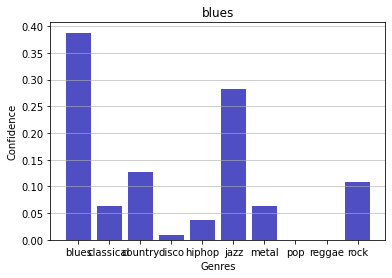

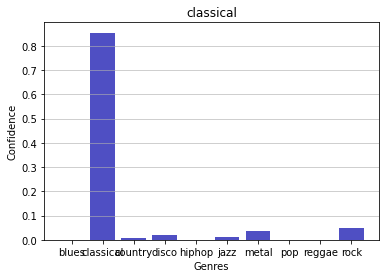

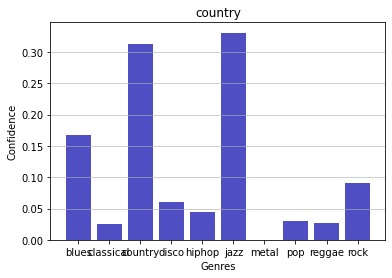

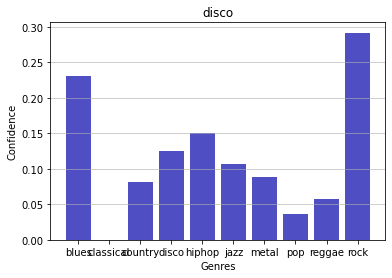

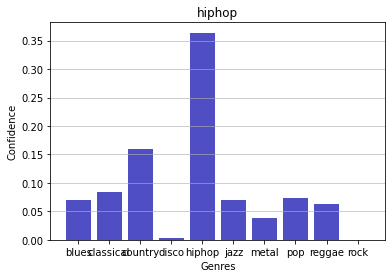

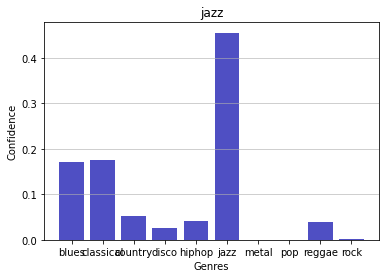

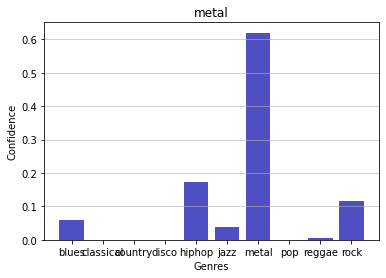

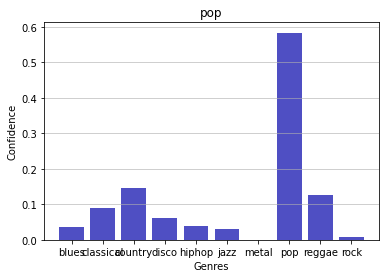

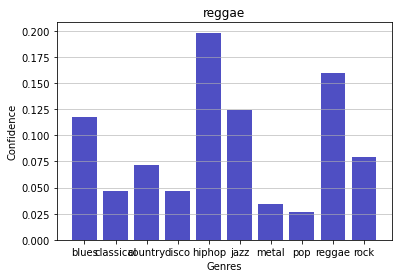

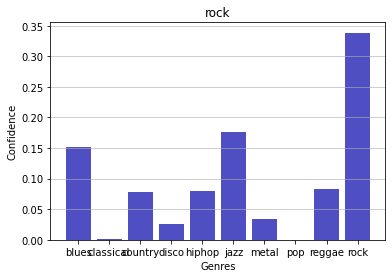

In [37]:
counter = 0
for dist in pred_data:
    plt.figure(counter)
    plt.bar(x=genres, height=dist, color='#0504aa', alpha=0.7, width=0.8)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Genres')
    plt.ylabel('Confidence')
    plt.title(genres[counter])
    counter += 1